In [4]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import pairwise_distances
import phate
import scprep

os.chdir('../../src')
import mappings
import data_loader

FileNotFoundError: [Errno 2] No such file or directory: '../../src'

In [5]:
def make_palette_order(labels):
    label_order = np.sort(np.unique(labels))
    
    if len(label_order) <= 10:
        pop_colors = sns.color_palette("tab10")
    else:
        pop_colors = sns.color_palette("viridis", len(label_order))

    pop_pallette = {label:color for label,color in zip(label_order, pop_colors)}
    return label_order, pop_pallette

In [6]:
# Load MHI
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/MHI'
fname = 'gsa.17k/SGR-2227_MHI_biobank_GSAv3.0MD_609343_SNPs_16707_ids_2021-01-04.WR_hg38-updated.missing10perc.noMAF0.common1000G.noHLA.raw.cols1and7toend.hdf5'
metadata_file = 'MHI_poplabels.tsv'
data_path = os.path.join(exp_path, fname)
metadata_path = os.path.join(exp_path, metadata_file)

inputs_mhi, _, samples_mhi, snp_names_mhi, _, metadata_mhi = data_loader.load_data_MHI(data_path, metadata_path)

In [11]:
MHI_PCA = pd.read_csv('/lustre06/project/6065672/shared/MHI_GWAS_SHUANG/MHI_PCA', index_col=0)

In [8]:
# label colors are arbitrary
label_order_mhi, pop_pallette_mhi = make_palette_order(metadata_mhi)

In [9]:
# Severely imbalanced
np.unique(metadata_mhi['selfreported_pop'], return_counts=True)

(array(['Asian', 'Black', 'Caucasian', 'Hispanic', 'Native', 'NotDone'],
       dtype=object),
 array([   66,   126, 16349,   118,     9,     4]))

# PCA plots

/tmp/ipykernel_1040827/4071028416.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


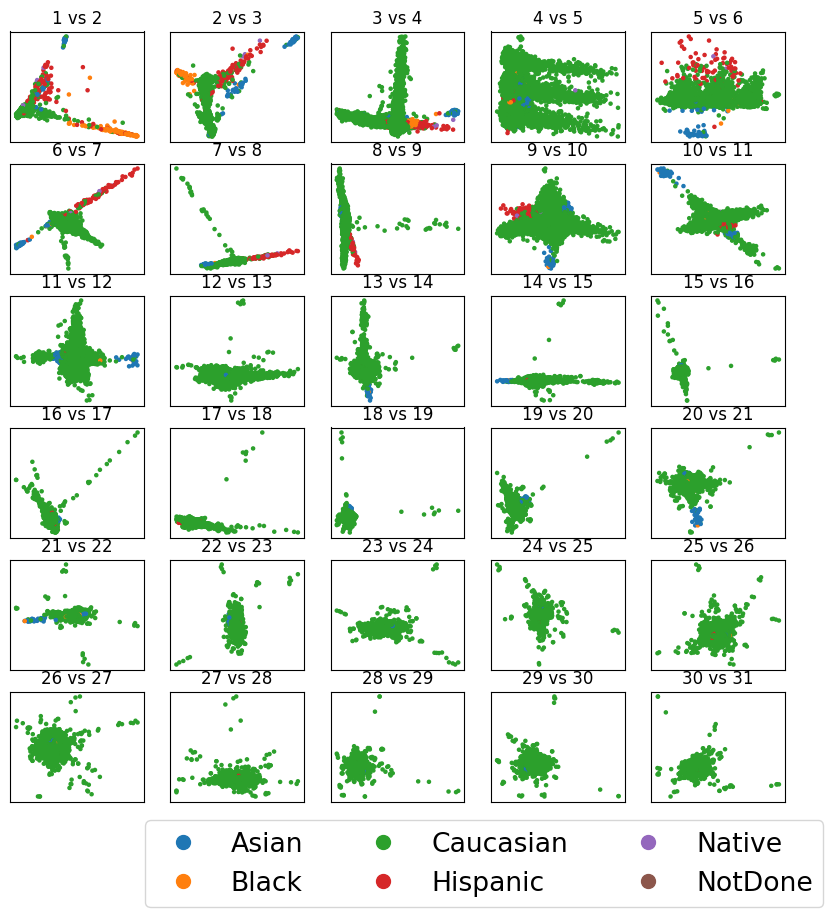

In [20]:
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(10, 10))

comp = 1
for i in range(6):
    for j in range(5):
        if (i == 5) & (j == 3):
            scprep.plot.scatter2d(MHI_PCA[[str(comp-1), str(comp)]], ax=ax[i, j],
                                  s=5, c=metadata_mhi['selfreported_pop'], 
                                  cmap=pop_pallette_mhi,
                                  xticks=False, yticks=False, legend=True,
                                  legend_loc='upper center', legend_anchor=(-0.05, -0.05), 
                                  legend_ncol=3, fontsize=16)
        else:
            scprep.plot.scatter2d(MHI_PCA[[str(comp-1), str(comp)]], ax=ax[i, j],
                                  s=5, c=metadata_mhi['selfreported_pop'], 
                                  cmap=pop_pallette_mhi,
                                  xticks=False, yticks=False, legend=False)

        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        ax[i, j].set_title('{} vs {}'.format(comp, comp+1), fontsize=12)

        comp += 1

plt.tight_layout()

# PHATE on MHI

In [19]:
phate_operator = phate.PHATE(random_state=2, knn=8, t=6, n_pca=None)
phate_operator.fit(MHI_PCA.values)
phate_emb_MHI = phate_operator.transform()

Running PHATE on 16672 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 25.55 seconds.
  Calculating affinities...
  Calculated affinities in 17.98 seconds.
Calculated graph and diffusion operator in 43.59 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 2.70 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.01 seconds.
Calculated landmark operator in 7.22 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.04 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.30 seconds.


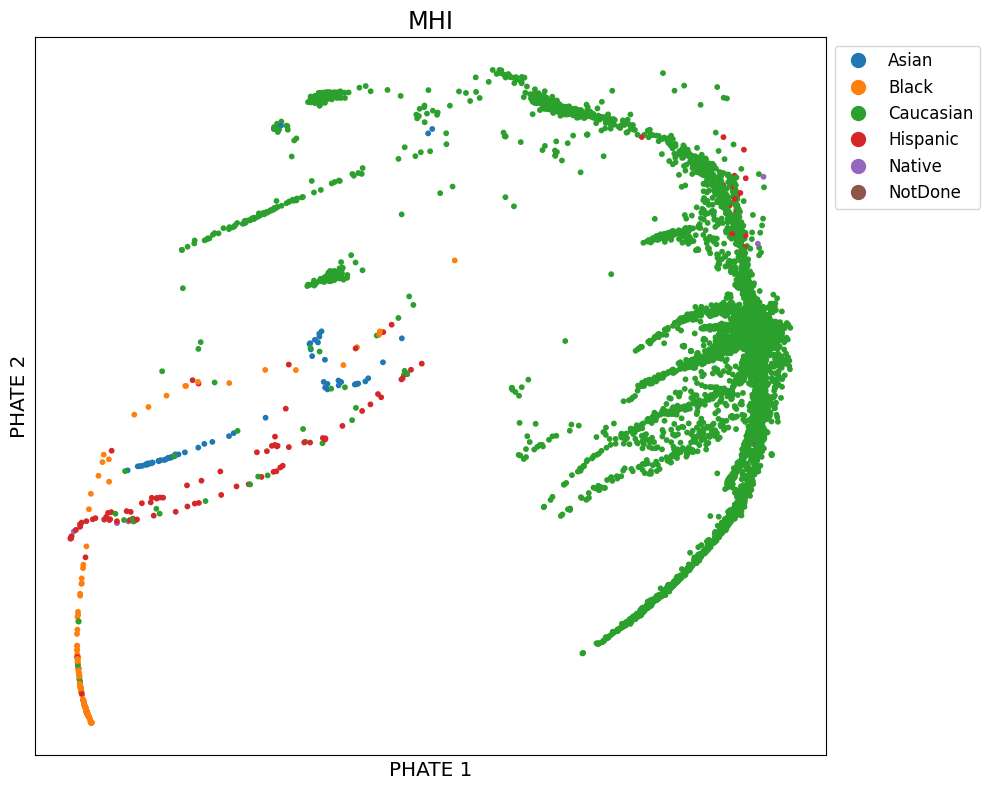

In [20]:
scprep.plot.scatter2d(phate_emb_MHI, s = 10, cmap=pop_pallette_mhi, 
                      legend_anchor=(1,1),legend_ncol=1, c=metadata_mhi['selfreported_pop'], 
                      xticks=False, yticks=False, figsize=(10, 8),
                      label_prefix="PHATE ", fontsize=10, title='MHI')
plt.savefig('../shuang/figures/PHATE_MHI.png', bbox_inches='tight') 